# Transfer learning

Das Ziel des Transferlearning ist es, ein bereits trainiertes Modell auf eine andere Aufgabe zu trainieren. Die Idee dahinter ist den Teil des Netzwerks, der für die Extraktion von Merkmalen zuständig ist, zu "recyceln". Da dies in der Regel der teuerste Teil des Trainings ist, spart man sich dadurch eine Menge an Zeit. Das bedeutet, dass dieser Teil nicht neu trainiert werden muss, sondern die bereits trainierte Featurextraktion genauso gut für eine ähnliche Aufgabe verwendet werden kann. Aus diesem Grund sollte man ein bereits trainiertes Netzwerk nutzen, welches für eine ähnliche Aufgabe trainiert wurde. Lediglich die Klassifikationsschicht wird neu trainiert. Ziel dieses Notebooks ist es, ein Verständnis zu bekommen, was beim Transferlearning passiert.

Schauen Sie sich folgendes Notebook an und versuchen Sie den groben Ablauf zu verstehen.
Sie werden die meisten Befehle die Sie benötigen darin finden.
https://www.tensorflow.org/tutorials/images/transfer_learning

Für diese Aufgabe wollen wir das in der letzten Aufgabe trainierte Convolutional Neural Network, welches auf dem Mnist Datensatz trainiert wurde, auf eine andere Aufgabe trainieren. Die Aufgabe des Netzwerks soll es sein, Hexadezimalzahlen zu erkennen.
Hierzu verwenden wir den $\textit{emnist}$ Datensatz. Dieser beinhaltet zusätzlich das Alphabet (große und kleine Buchstaben). Näheres dazu unter https://pypi.org/project/emnist/ 

Gehen Sie dazu wie folgt vor:

    * Laden Sie ihr Modell aus der vorherigen Aufgabe mit tf.keras.models.load_model("Name des Modells") Falls Sie ihr Modell nicht gespeichert hatten, können Sie dies mit model.save("Name des Modells"), nachdem Sie erneut trainiert haben, tun.
      
    * Bereiten Sie den emnist-Datensatz wie in der vorherigen Aufgabe vor und sortieren Sie alle Kleinbuchstaben sowie alle Buchstaben, die nicht der Hexadezimalschreibweise angehören, aus!
      
    * Laden Sie das zuvor gespeicherte Modell und entfernen Sie die letzte Schicht ( model.pop() )
    
    * Frieren Sie das Modell ein, d.h. Sie setzen die Layer auf nicht trainierbar
    
    * Fügen Sie eine neue Schicht hinzu, sodass die verschiedenen Klassen (0-F) klassifiziert werden können (Wir beschränken uns hier auf die groß geschriebenen Buchstaben)
    
    * Trainieren Sie das Netzwerk mit den transformierten Labels
    
    * Plotten Sie wieder die Trainingskurven und erstellen sie eine confusion Matrix

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from sklearn.metrics import confusion_matrix 
from extra_keras_datasets import emnist

In [2]:
# Vorbereiten von Nist

(input_train, target_train), (input_test, target_test) = emnist.load_data(type='balanced')

# Sortieren Sie alle Ziffern aus, die unerwünscht sind!
# Hinweis: np.where ist hierfür recht Hilfreich
indices = []
for x in range(16):
    for i in np.where(target_train == x)[0]:
        indices.append(i)
x_train = []
y_train = []
for i in indices:
    x_train.append(input_train[i])
    y_train.append(target_train[i])
indices = []
for x in range(16):
    for i in np.where(target_test == x)[0]:
        indices.append(i)
x_test = []
y_test = []
for i in indices:
    x_test.append(input_test[i])
    y_test.append(target_test[i])
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=69)
x_test, y_test = shuffle(x_test, y_test, random_state=69)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

INFO:root:Loading dataset = emnist
(38400, 28, 28)
(38400,)
(6400, 28, 28)
(6400,)


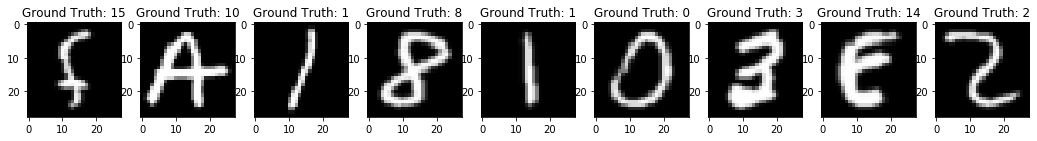

In [3]:
# Plotten Sie hier ein paar Ziffern!
plt.figure(figsize=(20,20))
for i in range(1,10):
    plt.subplot(1,10,(i+1))
    plt.imshow((x_train[i]),cmap="gray")
    plt.title("Ground Truth: {}".format(y_train[i]))
    #plt.axis('off')

In [4]:
# Normalisieren Sie das Set und bringen es in die richtige "shape"
import keras
x_train = x_train / 255
y_train = keras.utils.to_categorical(y_train,16)
x_test = x_test / 255
y_test= keras.utils.to_categorical(y_test,16)

x_train = np.reshape(x_train, (x_train.shape[0],28,28,1))
x_test = np.reshape(x_test, (x_test.shape[0],28,28,1))
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(38400, 28, 28, 1)
(38400, 16)
(6400, 28, 28, 1)
(6400, 16)
Using TensorFlow backend.


In [5]:
# Laden des Modells
base_model = tf.keras.models.load_model("mnist")

#Hier die letzte Schicht entfernen
base_model.pop()

In [6]:

# Modell einfrieren
for layer in base_model.layers:
  layer.trainable = False

# Basismodell als Ausgangspunkt nehmen
inputs = tf.keras.Input(shape=(28, 28,1))
x = base_model(inputs, training=False)

# Hier einen Dense-layer und einmal Softmax hinzufügen, sodass die verschiedenen Klassen vorhergesagt werden! können!
last_layer = tf.keras.layers.Dense(16)(x)
output     = tf.keras.layers.Activation('softmax')(last_layer)

# Modell Zusammenfügen
model = tf.keras.Model(inputs, output)

In [12]:
# Modell Kompilieren, Kostenfunktion categorical_crossentropy, Optimizer Adam mit der learningrate 1e-4
model.compile(loss='categorical_crossentropy', optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4),metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1600)              18816     
_________________________________________________________________
dense (Dense)                (None, 16)                25616     
_________________________________________________________________
activation (Activation)      (None, 16)                0         
Total params: 44,432
Trainable params: 25,616
Non-trainable params: 18,816
_________________________________________________________________


In [13]:
# Accuracy vor dem Transferlearning bestimmen
loss0, accuracy0 = model.evaluate(x = x_test,y = y_test)

6400/6400 [==============================] - 4s 590us/sample - loss: 4.1186 - accuracy: 0.0455


In [14]:
# Hier das Netzwerk für 10 Epochen trainieren!
history=model.fit(x_train, y_train, 
                  batch_size=128, 
                  epochs=10,
                  verbose=2,
                  validation_data=(x_test, y_test)
                 )

Train on 38400 samples, validate on 6400 samples
Epoch 1/10
38400/38400 - 12s - loss: 1.3139 - accuracy: 0.6367 - val_loss: 0.5361 - val_accuracy: 0.8694
Epoch 2/10
38400/38400 - 11s - loss: 0.4069 - accuracy: 0.9045 - val_loss: 0.3182 - val_accuracy: 0.9241
Epoch 3/10
38400/38400 - 11s - loss: 0.2770 - accuracy: 0.9334 - val_loss: 0.2419 - val_accuracy: 0.9409
Epoch 4/10
38400/38400 - 12s - loss: 0.2195 - accuracy: 0.9463 - val_loss: 0.2007 - val_accuracy: 0.9491
Epoch 5/10
38400/38400 - 11s - loss: 0.1858 - accuracy: 0.9536 - val_loss: 0.1752 - val_accuracy: 0.9547
Epoch 6/10
38400/38400 - 12s - loss: 0.1633 - accuracy: 0.9582 - val_loss: 0.1583 - val_accuracy: 0.9597
Epoch 7/10
38400/38400 - 12s - loss: 0.1468 - accuracy: 0.9623 - val_loss: 0.1451 - val_accuracy: 0.9623
Epoch 8/10
38400/38400 - 11s - loss: 0.1341 - accuracy: 0.9653 - val_loss: 0.1358 - val_accuracy: 0.9641
Epoch 9/10
38400/38400 - 12s - loss: 0.1241 - accuracy: 0.9679 - val_loss: 0.1279 - val_accuracy: 0.9672
Epoch 

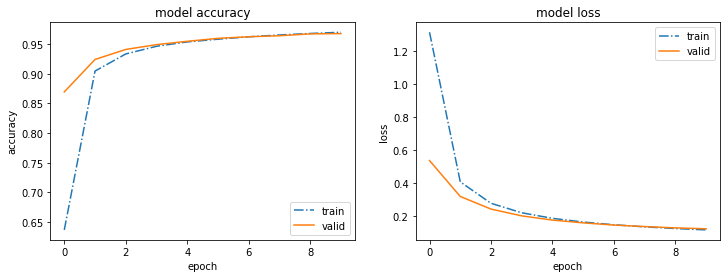

In [15]:
# Plotten der Trainingskurve wie in der Aufgabe zuvor
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

In [16]:
# Confusion Matrix erstellen
pred=model.predict(x_test)
print(confusion_matrix(np.argmax(y_test,axis=1),np.argmax(pred,axis=1)))
acc_fc_orig = np.sum(np.argmax(y_test,axis=1)==np.argmax(pred,axis=1))/len(pred)
print("Acc_fc_orig_flat = " , acc_fc_orig)

[[381   0   0   0   1   0   2   0   0   0   0   2   0  14   0   0]
 [  0 394   3   0   0   0   0   2   0   0   0   0   0   0   0   1]
 [  2   0 388   1   1   0   0   2   2   0   0   2   0   1   1   0]
 [  1   0   0 393   0   3   0   0   1   1   0   1   0   0   0   0]
 [  1   0   0   0 388   0   1   0   0   3   3   0   0   1   0   3]
 [  1   0   0   2   0 386   1   0   1   2   0   0   4   0   1   2]
 [  0   1   0   0   1   1 395   0   0   0   0   0   2   0   0   0]
 [  1   0   3   1   0   0   0 390   0   4   0   0   0   0   0   1]
 [  1   0   0   0   0   1   0   0 384   4   0   6   0   1   1   2]
 [  1   0   0   0   3   0   0   4   1 391   0   0   0   0   0   0]
 [  0   1   0   0   3   0   1   0   0   1 391   2   1   0   0   0]
 [  4   0   0   1   0   0   1   1   8   0   3 379   0   0   3   0]
 [  4   0   1   0   0   0   4   0   0   0   0   0 387   0   3   1]
 [ 22   0   0   1   1   1   0   1   0   0   1   4   1 367   1   0]
 [  0   0   0   0   0   2   0   0   0   1   0   1   0   0 392 